# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt

# Functions

In [2]:
def make_matrix(arr):
    X = (squareform(arr)).astype(float)
    row, col = np.diag_indices(X.shape[0])
    X[row,col] = np.ones(X.shape[0])
    for i in range(0, len(row)):
        for j in range(0, len(col)):
            if j < i:
                X[i, j] = (1 / X[i, j])
    return np.asarray(X)

def AHP_1_Participant(arr):
    alpha = 0.1
    A = make_matrix(arr)
    n = len(A)
    x_ticks = ['C{}'.format(i) for i in range(1, n+1)]
    sums = np.array(pd.DataFrame(A).sum())
    ln_rgmm = np.log(A)
    rgmm_sum = np.array(np.exp(pd.DataFrame(ln_rgmm).sum(axis = 1) / n))
    rgmm_sum_2 = rgmm_sum.sum()
    rggm = rgmm_sum / rgmm_sum_2
    errors = np.zeros(np.shape(A))
    
    size = np.shape(errors)[1]
    for i in range(0, size):
        for j in range(0, size):
            errors[i, j] = np.log(A[i, j] * rggm[j] / rggm[i]) ** 2
    
    errors_sum = np.sum(errors, 0)
    error_calc = np.sqrt(errors_sum / (size - 1))
    rggm_cosh = rggm * np.cosh(error_calc)
    rggm_cosh_sum = np.sum(rggm_cosh)
    rggm_final = rggm_cosh / rggm_cosh_sum
    rggm_matmul = np.matmul(sums, rggm)

    plus_minus = rggm * np.sinh(error_calc)/rggm_cosh_sum
    cr0 = (rggm_matmul - n)/((2.7699*n-4.3513)-n)
    eig_val = np.linalg.eig(A)[0].max()
    eig_vec = np.linalg.eig(A)[1][:,0]
    p = np.round(np.real(eig_vec/eig_vec.sum()), 3)
    cr = np.round(np.real((eig_val - n)/((2.7699 * n - 4.3513) - n)), 3)
    evt = np.real(A * size / eig_val)

    for i in range(0, size):
        for j in range(0, size):
            evt[i, j] = evt[i, j]* rggm_final[j]

    pi_pi = np.zeros(np.shape(A))
    for i in range(0, size):
        for j in range(0, size):
            pi_pi[i, j] = rggm[j] / rggm[i]

    pi_pi_A = pi_pi * A
    pi_pi_A2 = np.zeros(np.shape(A))
    for i in range(0, size):
        for j in range(0, size):
            if pi_pi_A[i, j] > 1/9 and pi_pi_A[i, j] < 9:
                if pi_pi_A[i, j] > 1:
                    pi_pi_A2[i, j] = A[i, j] * pi_pi[i, j]
                else:
                    pi_pi_A2[i, j] = 1 / (A[i, j] * pi_pi[i, j])
            else:
                pi_pi_A2[i, j] = 0
    Consistency_ratio = list(pi_pi_A2[np.triu_indices(n, k = 1)])
    std = np.array(pd.DataFrame(evt).std(1))
    plt.title('A')
    g1 = sns.heatmap(pd.DataFrame(np.tril(A)), annot=True, cmap = "viridis", cbar=False)
    g1.set_xticklabels(x_ticks)
    g1.set_yticklabels(x_ticks)
    plt.show()
    plt.title('Consistency Ratio Matrix')
    g2 = sns.heatmap(pd.DataFrame(np.tril(pi_pi_A2)), annot=True, cmap = "viridis", cbar=False)
    g2.set_yticklabels(x_ticks)
    g2.set_xticklabels(x_ticks)
    plt.show()
    p = pd.DataFrame(p, columns = ['Weights'])
    p.index = p.index + 1
    p.index = 'Crit-' + p.index.astype(str)
    p['Weights'] = p['Weights'].astype(float).map("{:.2%}".format)
    p['Weights +/-'] = std
    p['Weights +/-'] = p['Weights +/-'].astype(float).map("{:.2%}".format)
    p['RGMM'] = rggm_final
    p['RGMM'] = p['RGMM'].astype(float).map("{:.2%}".format)
    p['+/-'] = plus_minus
    p['+/-'] = p['+/-'].astype(float).map("{:.2%}".format)
    print(p)
    print(' ')
    print('Consistency Ratio: {:.2%} & Consistency Ratio of Weighted: {:.2%}'.format(cr0, cr))
    return A, p, cr, rggm

def AHP_Consolidated(A, rggm, w = 1):
    n = len(A)
    logs = []
    for i in A:
        logs.append(np.array(np.log(i)))
    cons = np.zeros(np.shape(logs[0]))
    table_rggm = pd.DataFrame(rggm)
    table_rggm_ln = -table_rggm*np.log(table_rggm)
    alphas = table_rggm_ln.sum(1)
    alpha = np.exp(np.sum(alphas)/n)
    Da = np.exp(alpha)
    gammas0 = table_rggm.sum(0)/n
    gammas = -gammas0*np.log(gammas0)
    gamma = np.exp(np.sum(gammas))
    beta = gamma/alpha
    for i in logs:
        cons += i
    cons = cons/n
    cons_exp = (np.exp(cons))
    size = np.shape(cons_exp)[1]
    x_ticks = ['C{}'.format(i) for i in range(1, size+1)]
    ahp_cor1 = np.exp((-9/(size+8)*np.log(9/(size+8))-(size-1)*(1/(size+8)*np.log(1/(size+8)))))
    ahp_cor2 = np.exp((size-n)*(-1/(size+8)*np.log(1/(size+8)))+n*(-(n+8)/(size+8)/n*np.log((n+8)/(size+8)/n)))
    ahp_cor3 = size / ahp_cor1
    it0 = (cons_exp.sum(1)/10)
    it = np.matmul(cons_exp, it0)
    scale0 = it0 / np.max(it0)
    scale = it / np.max(it)
    for i in range(20):
        it = np.matmul(cons_exp, scale)
        scale = it / np.max(it)
    
    norm = np.zeros(len(scale))
    for i in range(len(scale)):
        norm[i] = scale[i] / sum(scale)
    p = pd.DataFrame(norm, columns = ['Cons Weights'])
    sum_cols = cons_exp.sum(0)
    lamda = (sum(sum_cols*norm))
    evt = np.real(size / lamda * cons_exp)
    for i in range(0, size):
        for j in range(0, size):
            evt[i, j] = evt[i, j]* norm[j]
    std = np.array(pd.DataFrame(evt).std(1))
    cr = (lamda - len(sum_cols)) / ((2.7699*len(sum_cols)-4.3513)-len(sum_cols))
    consensus = (1/beta-1/ahp_cor3)/(1-1/ahp_cor3)
    g = sns.heatmap(pd.DataFrame(np.tril(cons_exp)), annot=True, cmap = "viridis", cbar=False)
    g.set_xticklabels(x_ticks)
    g.set_yticklabels(x_ticks)
    plt.show()
    p.index = p.index + 1
    p.index = 'Crit-' + p.index.astype(str)
    p['Cons Weights'] = p['Cons Weights'].astype(float).map("{:.2%}".format)
    p['Weights +/-'] = std
    p['Weights +/-'] = p['Weights +/-'].astype(float).map("{:.2%}".format)
    print(p)
    print(' ')
    print('Consistency Ratio of Consolidated: {:.2%} \nConsensus: {:.2%}'.format(cr, consensus))
    return cons_exp, p, cr

# A11, weights, cr, rgmm11 = AHP_1_Participant([3, 1, 1/2])
# A12, weights, cr, rgmm12 = AHP_1_Participant([6, 3, 8])
# A13, weights, cr, rgmm13 = AHP_1_Participant([1/8, 1/3, 1/4, 1/2, 1/7, 1/5])

# cons_A, p, cr = AHP_Consolidated([A1, A2], [rgmm11, rgmm12])

# Instructions

### Analytical Hierarchy Process

$\newcommand{\A}{\begin{Bmatrix}
1 & w_1 & w_2 & w_3 & w_4 \\
\frac{1}{w_1} & 1 & w_5 & w_6 & w_7 \\
\frac{1}{w_2} & \frac{1}{w_5} & 1 & w_8 & w_9 \\
\frac{1}{w_3} & \frac{1}{w_6} & \frac{1}{w_8} & 1 & w_{10} \\
\frac{1}{w_4} & \frac{1}{w_7} & \frac{1}{w_9} & \frac{1}{w_10} & 1 \\
\end{Bmatrix}}$

$A = \A$

### Instructions
<br>
<div class="warning" style='background-color:#E9D8FD; color: #69337A; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>

1. Put the criterions in the rows and the columns of a matrix
2. Add a score to each $w_i$ (right upper part of the table)
    * If **vertical** criterion is more important, assign the cell with **$\frac{1}{w_i}$**
    * If **horizontal** criterion is more important, assign the cell with **$w_i$**
3. Feed the function `AHP_1_Participant` with the array of $w = [w_1, w_2, w_3, ..., w_i]$ keeping the **right order** and get 3 outputs: the *table A*, the *Weights of the criterions* and the *Consistency ratio* of the AHP
4. In case of consolidated weight of multiple participants use the output A_i of the AHP of the individual participants and feed them as $A = [A_1, A_2, A_3, ..., A_i]$ into the function `AHP_Consolidated` keeping the **right order** and get the *consolidated Weights of the criterions* and the *consolidated Consistency ratio*.

</div>

# Zaragoza Logistics Center (ZLC)

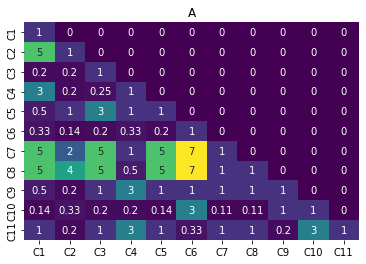

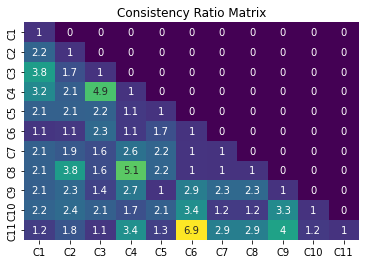

        Weights Weights +/-    RGMM     +/-
Crit-1    7.70%       5.86%   7.49%   5.04%
Crit-2   16.60%      10.70%  16.36%  10.61%
Crit-3    6.30%       6.53%   5.75%   3.93%
Crit-4    8.00%       7.92%   8.20%   6.38%
Crit-5    7.20%       3.91%   7.05%   3.90%
Crit-6    3.10%       4.25%   2.75%   1.91%
Crit-7   15.90%       8.08%  16.35%   9.64%
Crit-8   17.80%      12.86%  18.65%  13.16%
Crit-9    8.30%       7.81%   8.17%   5.86%
Crit-10   2.40%       2.01%   2.27%   1.45%
Crit-11   6.60%       5.51%   6.96%   5.29%
 
Consistency Ratio: 23.85% & Consistency Ratio of Weighted: 27.00%


In [3]:
arr = [0.2, 5, 0.333, 2, 3, 0.2, 0.2, 2, 7, 1, 5, 5, 1, 7, 0.5, 0.25, 5, 3, 5, 4, 0.333, 5, 0.2, 0.2, 1, 5, 1, 1, 3, 1, 2, 0.333, 5, 0.333, 5, 0.2, 0.2, 1, 7, 1, 0.143, 0.143, 1, 0.333, 3, 1, 1, 9, 1, 1, 9, 1, 1, 5, 0.333]
A1, weights, cr, rgmm1 = AHP_1_Participant(arr)

# Vrije Universiteit Brussel (VUB)

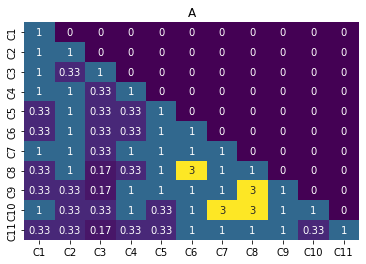

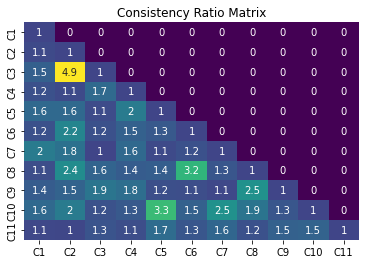

        Weights Weights +/-    RGMM     +/-
Crit-1   12.50%       4.33%  12.50%   4.42%
Crit-2   14.00%      14.23%  13.46%   8.32%
Crit-3   19.50%       8.07%  20.53%  11.13%
Crit-4   10.50%       4.36%  10.43%   4.12%
Crit-5    7.60%       5.58%   7.40%   3.68%
Crit-6    5.40%       2.74%   5.39%   2.53%
Crit-7    6.50%       2.99%   6.48%   2.86%
Crit-8    5.50%       4.00%   5.36%   2.97%
Crit-9    6.10%       3.26%   6.05%   2.60%
Crit-10   8.30%       4.54%   8.54%   4.76%
Crit-11   3.90%       1.15%   3.85%   1.20%
 
Consistency Ratio: 10.33% & Consistency Ratio of Weighted: 10.20%


In [4]:
arr = [1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 6, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 0.333, 1, 1, 1, 1, 1, 0.333, 1, 0.333, 0.333, 1, 1, 1, 3]
A2, weights, cr, rgmm2 = AHP_1_Participant(arr)

# Hellenic Institute of Transport (HIT)

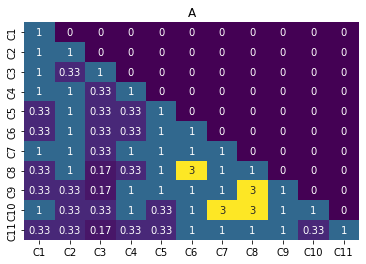

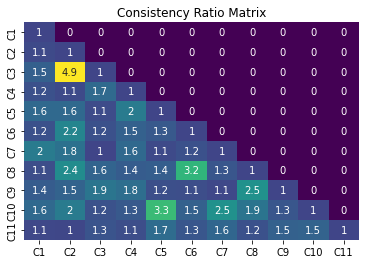

        Weights Weights +/-    RGMM     +/-
Crit-1   12.50%       4.33%  12.50%   4.42%
Crit-2   14.00%      14.23%  13.46%   8.32%
Crit-3   19.50%       8.07%  20.53%  11.13%
Crit-4   10.50%       4.36%  10.43%   4.12%
Crit-5    7.60%       5.58%   7.40%   3.68%
Crit-6    5.40%       2.74%   5.39%   2.53%
Crit-7    6.50%       2.99%   6.48%   2.86%
Crit-8    5.50%       4.00%   5.36%   2.97%
Crit-9    6.10%       3.26%   6.05%   2.60%
Crit-10   8.30%       4.54%   8.54%   4.76%
Crit-11   3.90%       1.15%   3.85%   1.20%
 
Consistency Ratio: 10.33% & Consistency Ratio of Weighted: 10.20%


In [5]:
arr = [1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 6, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 0.333, 1, 1, 1, 1, 1, 0.333, 1, 0.333, 0.333, 1, 1, 1, 3]
A3, weights, cr, rgmm3 = AHP_1_Participant(arr)

# Wuppertal Institut fuer Klima (WIK)

## Stefan

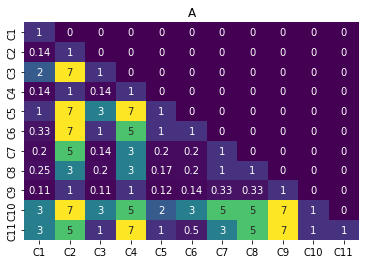

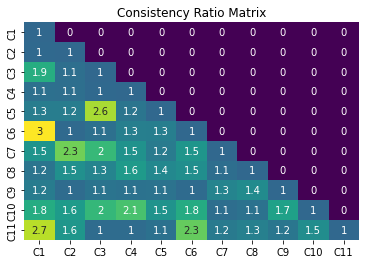

        Weights Weights +/-    RGMM    +/-
Crit-1   12.80%       8.07%  12.87%  6.60%
Crit-2    1.70%       0.58%   1.70%  0.60%
Crit-3   13.20%       6.04%  13.36%  6.01%
Crit-4    1.80%       0.73%   1.81%  0.57%
Crit-5   15.00%       7.71%  14.85%  5.38%
Crit-6   12.30%       5.78%  12.47%  5.94%
Crit-7    3.70%       1.68%   3.73%  1.54%
Crit-8    3.30%       0.98%   3.36%  1.00%
Crit-9    1.60%       0.44%   1.57%  0.38%
Crit-10  20.60%      10.86%  20.49%  9.64%
Crit-11  14.00%       7.95%  13.80%  5.94%
 
Consistency Ratio: 7.81% & Consistency Ratio of Weighted: 6.50%


In [6]:
arr = [7, 0.5, 7, 1, 3, 5, 4, 9, 0.333, 0.333, 0.143, 1, 0.143, 0.143, 0.2, 0.333, 1, 0.143, 0.2, 7, 0.333, 1, 7, 5, 9, 0.333, 1, 0.143, 0.2, 0.333, 0.333, 1, 0.2, 0.143, 1, 5, 6, 8, 0.5, 1, 5, 5, 7, 0.333, 2, 1, 3, 0.2, 0.333, 3, 0.2, 0.2, 0.143, 0.143, 1]
A4, weights, cr, rgmm4 = AHP_1_Participant(arr)

## Alvin

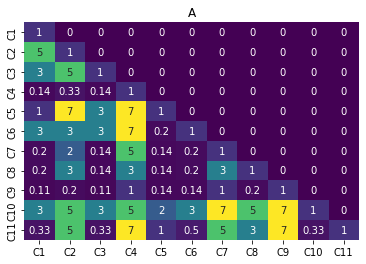

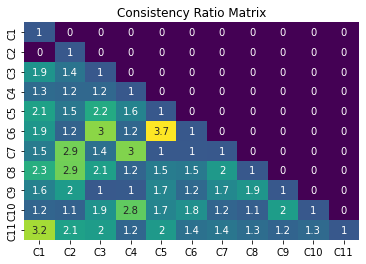

        Weights Weights +/-    RGMM     +/-
Crit-1    9.30%       6.04%  10.91%   8.26%
Crit-2    5.90%      12.32%   4.80%   3.60%
Crit-3   13.50%       7.74%  13.52%   7.55%
Crit-4    1.40%       0.74%   1.48%   0.71%
Crit-5   19.00%      14.36%  18.50%  10.83%
Crit-6   13.20%       8.78%  13.42%   7.59%
Crit-7    2.80%       2.12%   2.58%   1.38%
Crit-8    4.20%       2.92%   3.93%   2.14%
Crit-9    1.40%       0.57%   1.42%   0.63%
Crit-10  20.20%       9.12%  20.59%   9.82%
Crit-11   9.00%       4.81%   8.84%   4.57%
 
Consistency Ratio: 15.81% & Consistency Ratio of Weighted: 18.80%


In [7]:
arr = [0.2, 0.333, 7, 1, 0.333, 5, 5, 9, 0.333, 3, 0.2, 3, 0.143, 0.333, 0.5, 0.333, 5, 0.2, 0.2, 7, 0.333, 0.333, 7, 7, 9, 0.333, 3, 0.143, 0.143, 0.2, 0.333, 1, 0.2, 0.143, 5, 7, 7, 7, 0.5, 1, 5, 5, 7, 0.333, 2, 0.333, 1, 0.143, 0.2, 5, 0.2, 0.333, 0.143, 0.143, 3]
A5, weights, cr, rgmm5 = AHP_1_Participant(arr)

## Consolidated WI

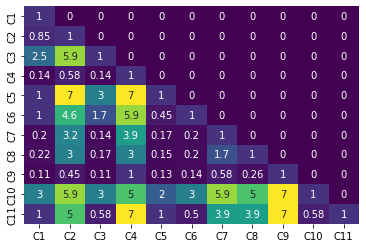

        Cons Weights Weights +/-
Crit-1        10.55%       4.26%
Crit-2         2.81%       1.91%
Crit-3        13.87%       6.27%
Crit-4         1.74%       0.83%
Crit-5        17.18%       8.86%
Crit-6        12.72%       5.11%
Crit-7         3.30%       1.99%
Crit-8         3.84%       1.80%
Crit-9         1.57%       0.53%
Crit-10       21.63%      10.04%
Crit-11       10.79%       2.77%
 
Consistency Ratio of Consolidated: 7.10% 
Consensus: 98.06%


In [8]:
cons_A_WUP, p, cr = AHP_Consolidated([A4, A5], [rgmm4, rgmm5])

# Cities and regions for transport innovation (POLIS)

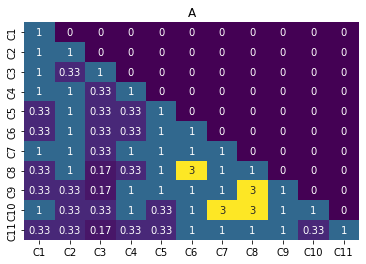

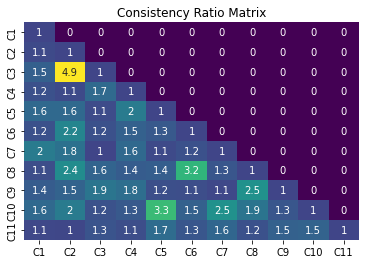

        Weights Weights +/-    RGMM     +/-
Crit-1   12.50%       4.33%  12.50%   4.42%
Crit-2   14.00%      14.23%  13.46%   8.32%
Crit-3   19.50%       8.07%  20.53%  11.13%
Crit-4   10.50%       4.36%  10.43%   4.12%
Crit-5    7.60%       5.58%   7.40%   3.68%
Crit-6    5.40%       2.74%   5.39%   2.53%
Crit-7    6.50%       2.99%   6.48%   2.86%
Crit-8    5.50%       4.00%   5.36%   2.97%
Crit-9    6.10%       3.26%   6.05%   2.60%
Crit-10   8.30%       4.54%   8.54%   4.76%
Crit-11   3.90%       1.15%   3.85%   1.20%
 
Consistency Ratio: 10.33% & Consistency Ratio of Weighted: 10.20%


In [9]:
arr = [1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 6, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 0.333, 1, 1, 1, 1, 1, 0.333, 1, 0.333, 0.333, 1, 1, 1, 3]
A6, weights, cr, rgmm6 = AHP_1_Participant(arr)

# Consolidated Weigths

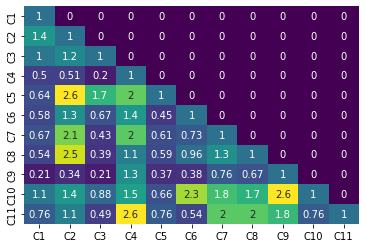

        Cons Weights Weights +/-
Crit-1        12.24%       4.06%
Crit-2         7.82%       3.79%
Crit-3        14.25%       4.29%
Crit-4         4.70%       1.60%
Crit-5        13.67%       4.90%
Crit-6         8.41%       3.04%
Crit-7         7.15%       3.11%
Crit-8         7.43%       3.77%
Crit-9         3.98%       1.15%
Crit-10       11.27%       2.86%
Crit-11        9.08%       2.92%
 
Consistency Ratio of Consolidated: 4.35% 
Consensus: 61.67%


In [10]:
# cons_A, p, cr = AHP_Consolidated([A1, A2, A3, A4, A5, A6], [rgmm1, rgmm2, rgmm3, rgmm4, rgmm5, rgmm6])
cons_A, p, cr = AHP_Consolidated([A1, A2, A4, A5], [rgmm1, rgmm2, rgmm4, rgmm5])